==============================================================================================
# Practicum 5 - Part 1

==============================================================================================

## Delivery

Up to **1 point out of 10** will be penalized if the following requirements are not fulfilled:

- Implemented code should be commented.

- The questions introduced in the exercises must be answered.

- Add title to the figures to explain what is displayed.

- Comments need to be in **english**.

- The deliverable must be a file named **P5_Student1_Student2.zip** that includes:
    - The notebook P5_Student1_Student2.ipynb completed with the solutions to the exercises and their corresponding comments.

**Deadline (Group A- Group F): November 23th, 23:00 h**

**Deadline (Group B): November 24th, 23:00 h**

==============================================================================================
##  Image search using textures
==============================================================================================

#### Problem we want to solve
- Given a query image **$x$** and a set of images **$X$** we would like to retreive the most similar to **$x$** images from  **$X$**.

The exercises of this notebook will show how we can perform image similarity search using:

**Part 1:**

- Gaussian filters
- Descriptors based on texture 

**Part 2:**

- Distance between images and similarity search


### Imports

In [95]:
%matplotlib inline

import time
import scipy
import numpy as np
import skimage
from skimage import filters
from skimage import io
from skimage.color import rgb2gray, rgba2rgb
from skimage.transform import resize
from scipy.ndimage import convolve

import os
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# 1 Leung-Malik (LM) Filter Bank
We can apply a collection of multiple filters that we call a filter bank. Note that if we apply $D$ filters our feature vectors will be $D$ dimensional.

The following image shows a filter bank. In the filter bank we typically want filters to capture a combination of scales, orientations of different types of patterns. This particular filter bank is The Leung-Malik (LM) Filter Bank.

<img src="./images_notebook/filter_bank.png">


We import Leung-Malik filters as follows:

In [96]:
import LM_filters
filter_bank = LM_filters.makeLMfilters()

**1.1** Check what the makeLMfilters reurn and plot all the filters using ``plt.subplots()``

**Hint:** In order to perform a correct visualization, please, check how many filters are in the filter bank.

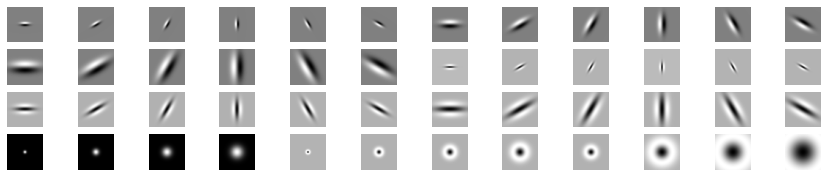

In [97]:
n_filters = filter_bank.shape[-1]

fig, ax = plt.subplots(ncols=12, nrows=4, figsize=(15,3))

k = 0
for i in range(4):
    for j in range(12):
        ax[i,j].imshow(filter_bank[:,:,k], cmap = 'gray')
        ax[i,j].axis("off")
        k = k + 1


Which is the size of the filters? How many filters there are?

In [ ]:
# Your solution here
"""
We can see this in the previous line of code "the shape of the filter bank is:  (49, 49, 48)"
Where each filter is 49x49 and there are 48 filters (48 channels)

Which is the size of the filters? 49x49, we can confirm this by commenting #ax[i,j].axis("off") from the previous code
How many filters there are? 48
"""

## Visualize Features

**1.2** Read the image ``/images/pizza.jpg``, and resize it to 250𝑥250 pixels. Then, convert the image to grayscale and visualize both, the RGB and the grayscale images.

(-0.5, 249.5, 249.5, -0.5)

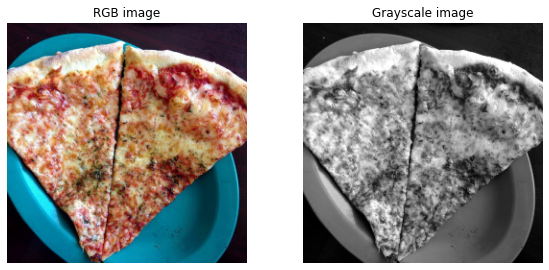

In [98]:
# Your solution here
pizza = io.imread("images/pizza.jpg")
pizza = resize(pizza, (250,250))
pizza_gray = rgb2gray(pizza)

#visualize
fig = plt.figure(figsize=(15,15))

fig.add_subplot(3,3,1)
plt.title('RGB image')
plt.imshow(pizza, cmap='gray')
plt.axis('off')

fig.add_subplot(3,3,2)
plt.title('Grayscale image')
plt.imshow(pizza_gray, cmap='gray')
plt.axis('off')

**1.3** Make a function `visualize_filters(im,  filter_bank, n_filters=5)` that recieves the `filter_bank`, an image `im` and an integer `n_filters`. 

The function  must make a plot of two rows containing in the first row, in position $k$, the image convolved by filter $k$. In the second row, in position $k$, the image of the k'th filter. The result for `n_filter=5` should look like 


<img src="./images/filters.png" >

**Hint**: Note that since at this moment we are focusing on the texture, we will not use the color of the images.

In [99]:
def display(images, titles = None, size=(15,15)):
    """
    function to visualize imges with title, if passed. 
    """
    %matplotlib inline
    #create the figure
    fig, ax = plt.subplots(1, len(images), figsize=size)
    
    for i in range(len(images)):        
        
        ax[i].imshow(images[i], cmap='gray')
            
        if titles != None :            
            ax[i].set_title(titles[i]) #we add the title  
        ax[i].axis('off')
    
    # We show the result
    plt.show()

In [100]:
def visualize_filters(im,  filter_bank, n_filters=5):
    ## Complete this function
    """
    print(im.shape)
    print(filter_bank[:,:,1].shape)
    """
    im_gray = rgb2gray(im) #we make the image grayscale so the shape is the same as the filter of the filter bank
    rows = filter_bank.shape[-1] // n_filters
      
    images = []
    filters = []
    for i in range(n_filters):
        result = np.zeros(im_gray.shape)
        im_convolved = np.abs(convolve(im_gray, filter_bank[:,:,i], output = result ))
        
        #we save the results, so we can visualize them later
        images.append(im_convolved)
        filters.append(filter_bank[:,:,i])
        
    display(images)
    display(filters)
    

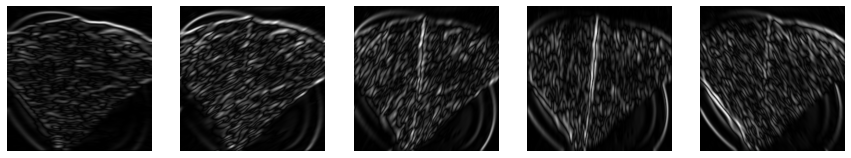

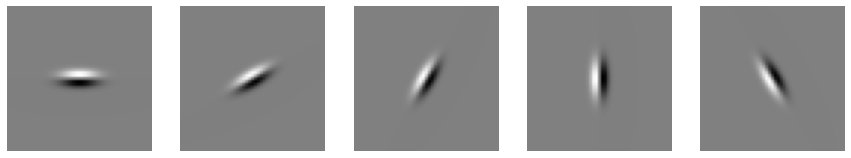

In [101]:
## Try the function
visualize_filters(pizza, filter_bank)

**1.4** (Optional) Try ``visualize_filters()`` using a different number of filters and using another image (for instance ``/images/dog.jpg`` or ``/images/flower.jpg``)

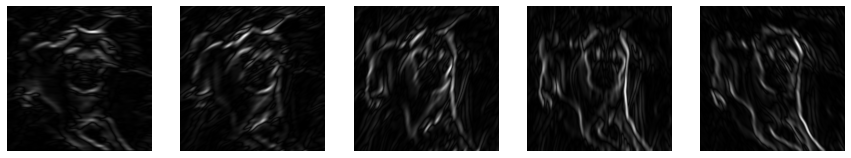

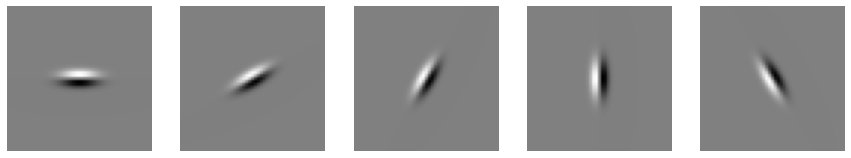

In [102]:
# Your solution here
dog = io.imread('images/dog.jpg')
dog = resize(dog, (250,250))
#dog_gray = rgb2gray(dog) the function already does this
visualize_filters(dog, filter_bank)

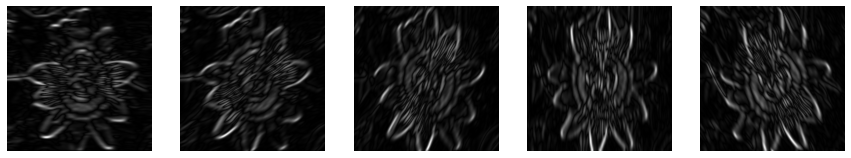

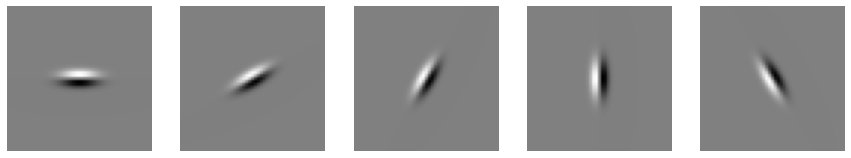

In [103]:
# Your solution here
flower = io.imread('images/flower.jpg')
flower = resize(flower, (250,250))
#flower_gray = rgb2gray(flower)
visualize_filters(flower, filter_bank)


### Extracting a feature vector for an image

**1.5** Given $D$ filters from the filter bank and a single image `image`, make a function `extract_features(image, filter_bank, n_filters)` that returns a feature vector of shape `n_filters`. The returned vector must contain at position $k$ the mean of the absolute value of the convolved image by filter $k$.

$$
\text{feat}(x) = \left( \text{mean}( |r_1|), \dots,\text{mean}(|r_D|) \right)
$$

Try the function with the previous image and print the feature vector.

**Hint**: The function should return a feature vector obtained by averaging each filter response on the image.  




In [28]:
def extract_features(image, filter_bank, n_filters):
    features = np.zeros(n_filters)
    
    ## Complete this function
    image_gray = rgb2gray(image) #we make the image grayscale so the shape is the same as the filter of the filter bank
      
    images = []
    filters = []
    for i in range(n_filters):
        #at position  i  the mean of the absolute value of the convolved image by filter  i.
        features[i] = np.mean(np.abs(convolve(image_gray, filter_bank[:,:,i])))
        
    return features

In [29]:
## Try the function
n_filters = filter_bank.shape[-1]
features = extract_features(pizza, filter_bank, n_filters)
print(features)

[1.58030226e-02 1.43530700e-02 1.41489582e-02 1.57999074e-02
 1.70876971e-02 1.72832990e-02 1.00621562e-02 8.59869296e-03
 7.95522798e-03 8.67853597e-03 9.89674213e-03 1.07254142e-02
 7.66968999e-03 6.44975108e-03 5.49431671e-03 5.72522331e-03
 6.72369567e-03 7.87234799e-03 7.06673483e-03 6.39564184e-03
 6.39084206e-03 7.49274570e-03 7.76181953e-03 7.70747440e-03
 2.30941988e-03 1.98230565e-03 1.90826488e-03 2.31078413e-03
 2.51654207e-03 2.53182227e-03 1.18212514e-03 9.70020643e-04
 9.25453648e-04 1.05649939e-03 1.21335886e-03 1.29035639e-03
 1.53557144e+00 3.07114288e+00 4.60671426e+00 6.14210805e+00
 7.67785721e-01 3.83892860e-01 2.55928444e-01 1.91831073e-01
 2.55928444e-01 1.17915282e-01 3.74541655e-02 3.39355233e-03]



**2.2** (Optional) Try ``extract_features()`` using a different number of filters and other images (for instance ``/images/dog.jpg`` or ``/images/flower.jpg``)


In [30]:
# Your solution here
n_filters = filter_bank.shape[-1]
features = extract_features(dog, filter_bank, n_filters)
print(features)

[6.62132888e-03 6.52005891e-03 7.58003570e-03 8.77490250e-03
 8.57723387e-03 7.60585823e-03 4.64930732e-03 4.65740759e-03
 5.26748523e-03 6.10800190e-03 6.23186052e-03 5.56509891e-03
 3.58744006e-03 3.70955039e-03 4.10476424e-03 4.57567342e-03
 4.94961654e-03 4.37442504e-03 2.08287147e-03 2.19140124e-03
 2.62934721e-03 3.25286666e-03 3.15027147e-03 2.49612573e-03
 8.66219655e-04 8.86275929e-04 1.03510334e-03 1.35096108e-03
 1.31518991e-03 1.06156312e-03 4.92501984e-04 5.24130172e-04
 6.02473312e-04 7.61905208e-04 7.71540103e-04 6.44375018e-04
 1.14866819e+00 2.29733637e+00 3.44600451e+00 4.59453981e+00
 5.74334093e-01 2.87167047e-01 1.91444601e-01 1.43497231e-01
 1.91444601e-01 8.82052959e-02 2.80171975e-02 2.32598530e-03]


## 2 Load & resize the dataset

**2.1** Read all the images in the directories, resized them to 250x250 pixels and save the image in an array:

<ul>
    <li>./images/pizza/</li>
    <li>./images/flowers/</li>
    <li>./images/pets/</li>
</ul>

**Hint:** You have to create an array for each directory, which containts all the images belonging to that path.

**Hint:** You need to use ``os.listdir()`` to list all the images for each directory.

In [31]:
# Your solution here
"""
we can use list comprehension to do this, by calling the function resize with the parameter of the read image and the size
for each iteration until we go trhough the entire folder, appending the resized image to the new list.
"""
pizza_images = [resize(skimage.io.imread('./images/pizza/' + i), (250, 250)) for i in os.listdir('./images/pizza/')]
flowers_images = [resize(skimage.io.imread('./images/flowers/' + i), (250, 250)) for i in os.listdir('./images/flowers/')]
pets_images = [resize(skimage.io.imread('./images/pets/' + i), (250, 250)) for i in os.listdir('./images/pets/')]

Visualize one image (the first) from each array. Use ``subplot`` to create a 3x1figure.

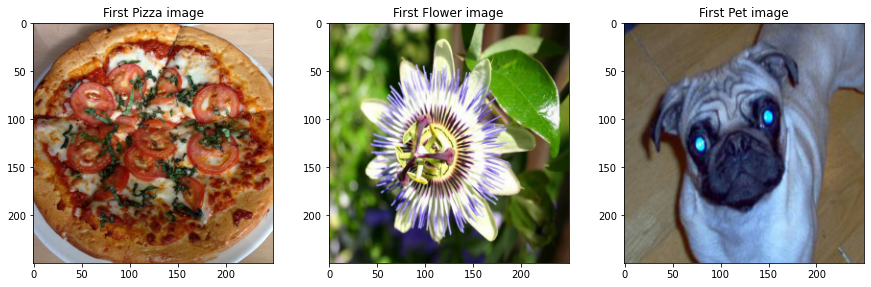

In [32]:
# Your solution here
fig = plt.figure(figsize=(15,15))

fig.add_subplot(3,3,1)
plt.title('First Pizza image')
plt.imshow(pizza_images[0], cmap='gray')

fig.add_subplot(3,3,2)
plt.title('First Flower image')
plt.imshow(flowers_images[0], cmap='gray')

fig.add_subplot(3,3,3)
plt.title('First Pet image')
plt.imshow(pets_images[0], cmap='gray')

How many images there are in each directory?

In [33]:
# Your solution here
print('Pizza images: ' + str(len(pizza_images)))
print('Flower images: ' + str(len(flowers_images)))
print('Pet images: ' + str(len(pets_images)))

Pizza images: 30
Flower images: 28
Pet images: 29


### Constructing the matrix of the feature vectors for all images

**2.2** Implement a function `get_dataset_features(all_images, filter_bank)` that applies `extract_features` to get a feature vector for each of the images in the union of the three datasets (fish and chips_images, pizza, paella). It must return a matrix containing at row $k$ feature vector for the input image $k$.

Try the function with the whole data set:

*all_images = pizza_images + flowers_images + pets_images*

In [34]:
%%time
def get_dataset_features(all_images,  filter_bank):
    n_images = len(all_images) #I'm assuming this refers to the number of images
    n_filters = filter_bank.shape[-1]
    feature_vectors=np.zeros((n_images,n_filters))
    
    ## Complete this function
    
    for i in range(n_images):
        feature_vectors[i] = extract_features(all_images[i], filter_bank, n_filters)
        
    return feature_vectors

Wall time: 0 ns


In [ ]:
"""
WARNING: this functions takes a lot of time to compile. Over 10min
"""

In [35]:
## Try the function
all_images = pizza_images + flowers_images + pets_images
feature_vectors=get_dataset_features(all_images,  filter_bank)

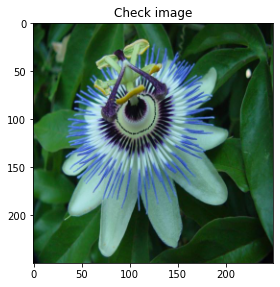

In [104]:
fig = plt.figure(figsize=(15,15))

fig.add_subplot(3,3,1)
plt.title('Check image')
plt.imshow(all_images[57], cmap='gray')

**2.3** Print the shape of `feature_vectors` as well as the features for image #0 (*i.e. all_images[0]*), image #30, and image #59, directly from the vector

In [38]:
print(feature_vectors)

[[0.0172559  0.01644058 0.01479478 ... 0.11733988 0.0372714  0.00282648]
 [0.01005518 0.01068532 0.01122815 ... 0.14770367 0.04691604 0.00324634]
 [0.02171766 0.01964706 0.01623778 ... 0.15197135 0.04827161 0.00381521]
 ...
 [0.01354879 0.01339139 0.01409534 ... 0.11803887 0.03749342 0.00343867]
 [0.01344312 0.01329617 0.01415635 ... 0.1325186  0.04209271 0.00362301]
 [0.01378077 0.01395461 0.01474518 ... 0.13194069 0.04190914 0.00379904]]


In [39]:
# Your solution here
print(feature_vectors.shape)

(87, 48)


In [40]:
# Your solution here
print('Features for image 0 : ' + str(feature_vectors[0]))
print('Features for image 30 : ' + str(feature_vectors[30]))
print('Features for image 59 : ' + str(feature_vectors[59]))

Features for image 0 : [1.72558991e-02 1.64405826e-02 1.47947771e-02 1.36167461e-02
 1.41317260e-02 1.56693482e-02 9.99954728e-03 9.08532685e-03
 8.04501303e-03 7.37077731e-03 7.74814926e-03 8.74499247e-03
 6.76226404e-03 6.08378843e-03 5.11410935e-03 4.84727425e-03
 5.38600349e-03 5.98291181e-03 8.03727392e-03 7.59679589e-03
 6.99035925e-03 6.30493242e-03 6.74072480e-03 7.43274621e-03
 2.70821493e-03 2.38752031e-03 2.21787896e-03 1.92192867e-03
 2.08134583e-03 2.31049376e-03 1.31501997e-03 1.14185964e-03
 1.02552750e-03 8.95460630e-04 9.95367256e-04 1.11154531e-03
 1.52807819e+00 3.05615639e+00 4.58423451e+00 6.11213592e+00
 7.64039096e-01 3.82019548e-01 2.54679570e-01 1.90894979e-01
 2.54679570e-01 1.17339882e-01 3.72713974e-02 2.82647993e-03]
Features for image 30 : [1.54756520e-02 1.58441523e-02 1.81523977e-02 1.98340443e-02
 1.88133947e-02 1.68146553e-02 1.02816167e-02 1.02377449e-02
 1.19416332e-02 1.31870734e-02 1.19260264e-02 1.06705434e-02
 7.65175005e-03 7.37325292e-03 8.6081

### Visualizing the features of an image

**2.4** Define a function `visualize_features` that given three different images, plots their features. Use different colors (red, green, and blue) to distinguish the features of each image.
Choose 3 images on your choice and visualize the results.

In [41]:
def visualize_features(im_index, feature_vector):
    ## Complete this function
    """
    im_index is a list that contains the indexes of the three images
    Since all images have 48 features, we iterate over the number of features, printing the corresponding
    feature values for each image.
    """
    
    for i in range(feature_vectors.shape[1]): #the number of features each image has (48)
        #we print all feature values for images 1, 2, and 3
        im1 = plt.scatter(im_index[0], feature_vectors[im_index[0]][i], c = "red")
        im2 = plt.scatter(im_index[1], feature_vectors[im_index[1]][i], c = "green")
        im3 = plt.scatter(im_index[2], feature_vectors[im_index[2]][i], c = "blue")
    
    plt.legend((im1, im2, im3),('Image 1','Image 2','Image 3'), scatterpoints = 1, loc = 'best', ncol = 3)        
    plt.xlabel('Images')
    plt.ylabel('Feature Values')
    plt.title("Feature values of images: " + str(im_index))
    plt.show()
   

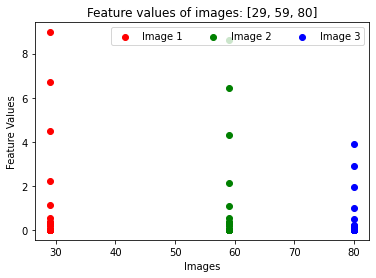

In [42]:
## Try the function
visualize_features([29, 59, 80], feature_vectors)

**2.5** (Optional) Try the function using a different set of images

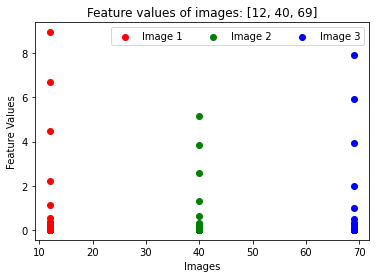

In [43]:
# Your solution here
visualize_features([12, 40, 69], feature_vectors)

Explain which features are most important to a given image and with each derivatives are related.

In [ ]:
"""
being that the feature is how the image reacts to an applied filter, the one with the biggest reaction gives the most important
result.
"""

### Similarity search

Let us assume $f(x) \in \mathbb{R}^D$ represents a set of features for $x$. Given a query image $x$ and another image $x^m$ from the database, we can compute the distance between images as
$$
\text{distance}\left( f(x) , \, f(x^m) \right) = \| \text{feat}(x)  - \text{feat}(x^m)  \|_2 =  \sqrt{ \sum_{d=1}^\text{D} \left( f(x)_d - f(x^m)_d  \right)^2 }
$$

then we can find the closest image $x^{m^*}$ from the database to $x$ as $m^* =  \text{argmin}_{m} \{ \| \text{feat}(x)  - \text{feat}(x^m)  \|_2 \}$



**2.5** Extract the image features using ``pizza.jpg`` and look for the most similar image in the whole dataset by comparing its features with those extracted from ``all_images``. What index was found in ``feature_vectors``?

Show the two images.


In [105]:
# Returns the k images that are closer to the query image
def most_similar_image(img_features, feature_vectors, all_images):
    """
    we use eucledian distance to find the most similar image, from all images. Since the feature_vector indexes are the same
    for all images (feature_vector[1] has the features for image at all_images[1]) we can just apply the formula, add the 
    result to a list, with the corresponding index, sort that list so we get smallest distance (most similar) to bigger 
    distance (least similar), then we just need to return all_images[distances[1][1]] because distance[n][1] has the 
    image index, the index we want to use for all_images. 
    """
    #a list to save all the distances
    distances = []          
    for i in range(len(feature_vectors)):
        similarity = np.sqrt(np.sum((img_features - feature_vectors[i])**2))
        distances.append([similarity, i]) #save distance and index

    distances.sort(reverse = False)
    #print(distances) #all_images[distances[0][1]]
    #we return at [1][1] because the most similiar image will be it self, so we return the second most similar
    return all_images[distances[1][1]] 


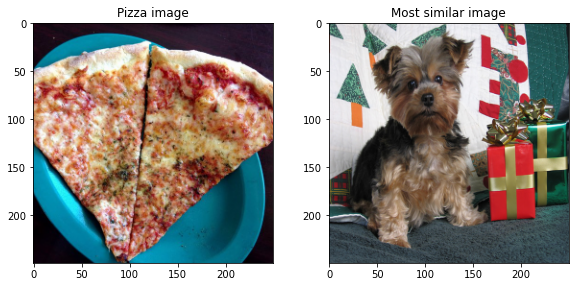

In [107]:
# Your solution here
pizza_features = extract_features(pizza, filter_bank, n_filters)
image = most_similar_image(pizza_features, feature_vectors, all_images)

#visualize
fig = plt.figure(figsize=(15,15))

fig.add_subplot(3,3,1)
plt.title('Pizza image')
plt.imshow(pizza, cmap='gray')

fig.add_subplot(3,3,2)
plt.title('Most similar image')
plt.imshow(image, cmap='gray')

**2.6** (Optional) Repeat the process using ``/images/dog.jpg`` and ``/images/flower.jpg``

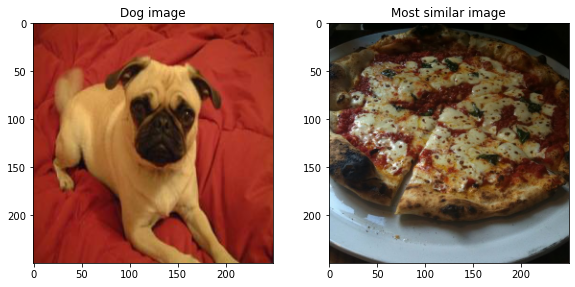

In [109]:
# Your solution here
dog_features = extract_features(dog, filter_bank, n_filters)
image = most_similar_image(dog_features, feature_vectors, all_images)

#visualize
fig = plt.figure(figsize=(15,15))

fig.add_subplot(3,3,1)
plt.title('Dog image')
plt.imshow(dog, cmap='gray')

fig.add_subplot(3,3,2)
plt.title('Most similar image')
plt.imshow(image, cmap='gray')

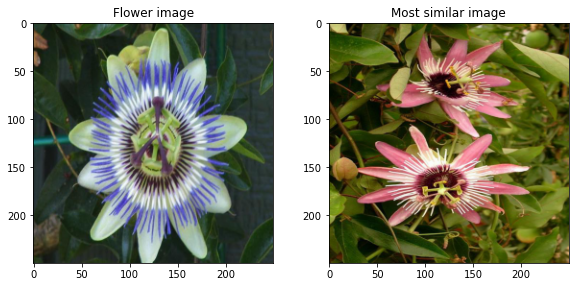

In [110]:
# Your solution here
flower_features = extract_features(flower, filter_bank, n_filters)
image = most_similar_image(flower_features, feature_vectors, all_images)

#visualize
fig = plt.figure(figsize=(15,15))

fig.add_subplot(3,3,1)
plt.title('Flower image')
plt.imshow(flower, cmap='gray')

fig.add_subplot(3,3,2)
plt.title('Most similar image')
plt.imshow(image, cmap='gray')